In [1]:
%config IPCompleter.greedy=True

import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing, sklearn.datasets, sklearn.model_selection
import timeit

In the previous chapter, I introduced logistic regression and how it makes predictions. I as well pointed out, that unlike Perceptron, logistic regression returns the probability of datapoints belonging to the specific class. However, I didn't mention the training algorithm for it. That would be the content of this chapter.

I also demonstrated the gradient descent algorithm in the second half of the previous chapter. There will be no surprise, that the gradient descent is the exact algorithm we are going to use in this chapter to train logistic regression.

# Logistic regression training

We now should have all the knowledge we need to train logistic regression. For a reminder, the prediction of the logistic regression is:

$$
f(\pmb{x})=\frac{1}{1+e^{-\pmb{x}\pmb{w}^T}}
$$

In able to use gradient descent, we need some function, that the algorithm is going to optimize. That's why I showed a loss function. When we plug it in, we obtain the following formula.

$$
\mathcal{L}=\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2 = \frac{1}{2} \sum_{i=0}^{n} \left( t_i - \frac{1}{1+e^{-\pmb{x}\pmb{w}^T}} \right)^2
$$

Now we want to update the weights, so we need to compute the gradient of the loss function with respect to weight (and we need to compute it for every weight). In this case, we can use the chain rule.

$$
\frac{\partial \mathcal{L}}{\partial w_i} = \frac{\partial \mathcal{L}}{\partial f(\pmb{x})} \cdot \frac{\partial f(\pmb{x})}{\partial \pmb{x}\pmb{w}^T} \cdot \frac{\partial \pmb{x}\pmb{w}^T}{\partial w_i}
$$

Then the gradient is easy to obtain (note that I mark $\sigma(x)$ as the sigmoid function, i.e. $\sigma(x)=\frac{1}{1+e^{-x}}$ and $y_i$ as the prediction of the model, i.e. $y_i = \sigma(\pmb{x}\pmb{w}^T)$.

$$\
\frac{\partial \mathcal{L}}{\partial w_i} = (t_i - y_i) \cdot -\sigma(\pmb{x}\pmb{w}^T)\left( 1 - \sigma(\pmb{x}\pmb{w}^T) \right) \cdot x_i
$$

> Note the minus in the second multiple. Because in the loss is $t_i - f(\pmb{x})$ (minus in front of the prediction), the whole derivative is multiplied by $-1$. We can alternatively ignore the minus sign and then add the gradient to the weights, so the final formula would be $w_i = w_i + \alpha \frac{\partial \mathcal{L}}{\partial w_i}$. I will stick with the proper mathematical formula - the gradient will be multiplied by $-1$ and I will subtract it from the weights. I just wanted to point this out, as the minus is sometimes forgotten.

Finally, let's put it all to the code.

I will use the same class as in the previous chapter (`Neuron`) and I will implement the fit method. Don't forget that the gradient descent algorithm needs learning rate, I will put it in the constructor.

In [2]:
class Neuron:
    def __init__(self, max_iters=100, random_state=None, learning_rate=0.001):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # Learning
        for iteration in range(self.max_iters):
            # shufle data randomly
            permutation = self._rand.permutation(len(X))       
            train_data = X[permutation]
            train_labels = y[permutation]
            # make gradient descent on each data point
            for datapoint, target in zip(train_data, train_labels):
                prediction = self.predict(datapoint)
                # compute gradient
                gradient = -(target - prediction) * (prediction * (1 - prediction)) * datapoint
                # update weights
                self._weights = self._weights - self._learning_rate * gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The algorithm makes `self.max_iters` iterations and in each iteration, it randomly shuffles the data and performs gradient descent for each data point. That means the algorithm will make `self.max_iters * len(X)` gradient descent executions during training. Let's see how the algorithm behaves on some dataset.

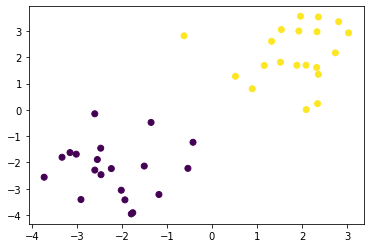

In [3]:
data, classes = sklearn.datasets.make_blobs(
    n_samples=40,
    n_features=2,
    centers=[[-2, -2], [2, 2]],
    random_state=42,
)
plt.scatter(data[:,0], data[:,1], c=classes)
plt.show()

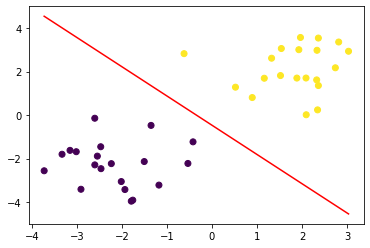

In [4]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
n = Neuron(random_state=41, max_iters=500, learning_rate=0.01)
n.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - n._weights[0] / n._weights[1]
bias = n._weights[2] / n._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

And that's it, we have working logistic regression. What we have done is called **Stochastic Gradient Descent** - it computes the gradient for every sample and updates the weights accordingly.

# Batch gradient descent

Let's think a little bit about the previous implementation. When we treat each data point separately, the optimum is "put the separating hyperplane as far as possible from this data point". In other words, when we have only one point and we want to minimalize the loss, the ideal separating hyperplane is infinitely far away from the datapoint (as only in infinity is the value of sigmoid 1 or 0, depending on the class). As a result, the algorithm can start oscillating the same way we have seen in the perceptron case.

However, what we really want, is the separating hyperplane that is optimal for all the data points we have. Let's look once again to the loss function.

$$
\mathcal{L}=\frac{1}{2} \sum_{i=0}^{n} \left( t_i - f(\pmb{x_i}) \right)^2 
$$

We silently ignored the sum, or more precisely we used only one data point so the sum disappeared. Let's now fix the algorithm and instead of updating the weights based on the simple sample, we are going to update it based on all the samples.

In [5]:
class Neuron:
    def __init__(self, max_iters=100, random_state=None, learning_rate=0.001):
        self.max_iters = max_iters
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        # Learning
        for iteration in range(self.max_iters):
            # predict the data
            prediction = self.predict(X)
            # table of gradient for each weights and gradient in the shape (samples,weights)
            gradient = np.reshape(-(y - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * X
            # sum gradient over the samples
            sum_gradient = np.sum(gradient, axis=0)
            # update the weights
            self._weights = self._weights - self._learning_rate * sum_gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

The implementation is almost the same. We first generate all the predictions for all the data points (that mean `prediction` is a vector), then compute the gradient of loss and sigmoid (the result is still a vector) and finally multiply each value with the corresponding data point. Because `X` is a matrix, we need to reshape the gradient (of loss in respect to $\pmb{x}\pmb{w}^T$) to the matrix of size `(samples,features)` so we can multiply it with matrix `X` of shape `(samples,features)` (in this case the real shape is `(samples,1)`). We obtain the gradient with respect to weights for each data point (that is `gradient` variable in the shape `(samples,features)`) and we sum it over the data points. Finally, we update the weights.

Note that we didn't shuffle the data this time, as it doesn't make sense. As the gradient for each data point is accounted for, the order of data points doesn't matter.

Now let's train the logistic regression and see the results.

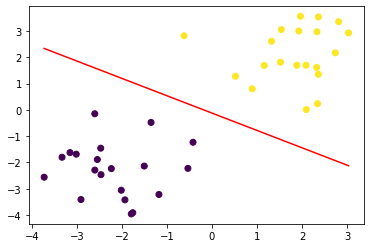

In [6]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
n = Neuron(random_state=42, max_iters=1000, learning_rate=0.05)
n.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - n._weights[0] / n._weights[1]
bias = n._weights[2] / n._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

The result seems to be a bit better than in the previous case. The algorithm keeps about the same distance from the first class as from the second one. Using all the data points at once, the algorithm can find the global minimum and will not oscillate.

Sometimes, this algorithm is just call **gradient descent** (instead of batch gradient descent). This makes sense as the algorithm in fact optimizes the global loss (instead of loss for individual data points). In most sources gradient descent (aka batch gradient descent) is shown first and then they start talking about its stochastic version. I decided to flip the order as from the implementation point of view, the stochastic version is easier to read (at least I believe so).

## Pros and cons

Now, when we have seen batch gradient descent (I will refer to it as gradient descent so on) and stochastic gradient descent, we should talk about the differences and what are their pros and cons.

+ Gradient descent is more stable and can result in faster convergence in some cases.
+ Gradient descent is usually more efficient, as the operations can be vectorized (performing the same operation over multiple data at once) and thus the algorithm can be faster.
+ Because the update is following the prediction, the algorithm can be parallelized into some level.
+ Gradient descent can get stuck in the local optimum more easily.
+ Gradient descent can have problems for big training sets, as the data don't need to fit into memory (nothing we would need to worry about so far). That may leads even to overflow when there are so many samples that the sum of gradients does not fit into memory (or the value would be simply too big).
+ Stochastic gradient descent updates weights more often and thus can lead to faster convergence.
+ Stochastic gradient descent is more computationally intensive.
+ Stochastic gradient descent can oscillate too much and avoid the global optimum (even good local optimum).

These algorithms are extremes, we update weights for every data point or for all the data points. It turns out the best approach is something between, which leads us to the following algorithm.

# Minibatch gradient descent

Minibatch gradient descent combines the approaches above. We provide the algorithm another parameter (called batch size). Before each iteration, the algorithm shuffles the data and split them into subsets of the same size (based on the batch size parameter) called batches. The weights update is then done for each batch separately.

The question you may ask is what to do with the last batch in case the number of data points is not divisible by the batch size. Well, we can ignore that batch or use it anyway. Note that the batch size should be in the order of magnitudes smaller than the data, so skipping it shouldn't have an impact on the training process. When we use it, the gradient can be noisier, but again, it shouldn't have an impact on the training process as there are plenty of batches before. I am going to use it, but if you don't want to, it is as easy as modifying the source code a little bit.

Before we dig into the code, I want to point one more small change in the terminology. What we called iteration before is now called epoch - one epoch is done when the algorithm processes all the data points in the set. One iteration is then done when one batch is processed.

In [7]:
class Neuron:
    def __init__(self, epochs=100, random_state=None, learning_rate=0.001, batch_size=16):
        # use epochs instead of iterations
        self.epochs = epochs
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        n_data = len(X)
        # Learning
        for epoch in range(self.epochs):
            # shuffle the data
            permutation = self._rand.permutation(n_data)
            # for each batch
            for batch_start in range(0, n_data, self._batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+self._batch_size]]
                batch_target = y[permutation[batch_start:batch_start+self._batch_size]]
                # predict the data
                prediction = self.predict(batch_data)
                # table of gradient for each weights and gradient in the shape (samples,weights)
                gradient = np.reshape(-(batch_target - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * batch_data
                # sum gradient over the samples
                sum_gradient = np.sum(gradient, axis=0)
                # update the weights
                self._weights = self._weights - self._learning_rate * sum_gradient
                
        return self
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

There are not many changes. First of all, we shuffle the data as we did in the stochastic gradient descent. We then iterate over the data and use Python's slicing capability to obtain one batch (we need to index the original data by the permutations).

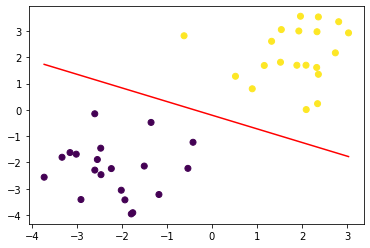

In [8]:
# Train the logistic regression
train_data = np.hstack([data, np.ones((data.shape[0],1))])  # add bias
n = Neuron(random_state=42, epochs=1000, learning_rate=0.01, batch_size=4)
n.fit(train_data, classes)

# Visualize results
plt.scatter(data[:,0], data[:,1], c=classes)
slope = - n._weights[0] / n._weights[1]
bias = n._weights[2] / n._weights[1]
plt.plot(
    [data.min(axis=0)[0], data.max(0)[0]], 
    [slope * data.min(axis=0)[0] - bias, slope * data.max(axis=0)[0] - bias],
    c='r')
plt.show()

The result is not surprising. In fact, all the algorithms look the same so far! Let's compare them on a bit more complicated example.

# Evaluation

To evaluate the performance, we are going to stick with the MNIST dataset once again. However, to speed up the training process, I will make some modifications. Instead of using all the digits, I will focus on 4 and 9 as they are quite similar and our model can so far predict only two classes.

In [9]:
X, y = sklearn.datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
one_or_seven_indices = np.logical_or(y == 4, y == 9)
data = X[one_or_seven_indices].reshape(-1, 784)
data[data < 128] = 0
data[data > 0] = 1
data = np.hstack([data, np.ones((data.shape[0],1))])
target = y[one_or_seven_indices].reshape(-1)
target[target==4] = 0
target[target==9] = 1
train_data, test_data, train_target, test_target = sklearn.model_selection.train_test_split(data, target, test_size=0.3, random_state=47)

You may notice I modified the values as well. Instead of using the whole greyscale spectrum, I am going to use only black and white pictures. You can see a few examples in the following pictures. The two last lines of the code relabel the targets so class $0$ corresponds to $4$ and class $1$ to class $9$.

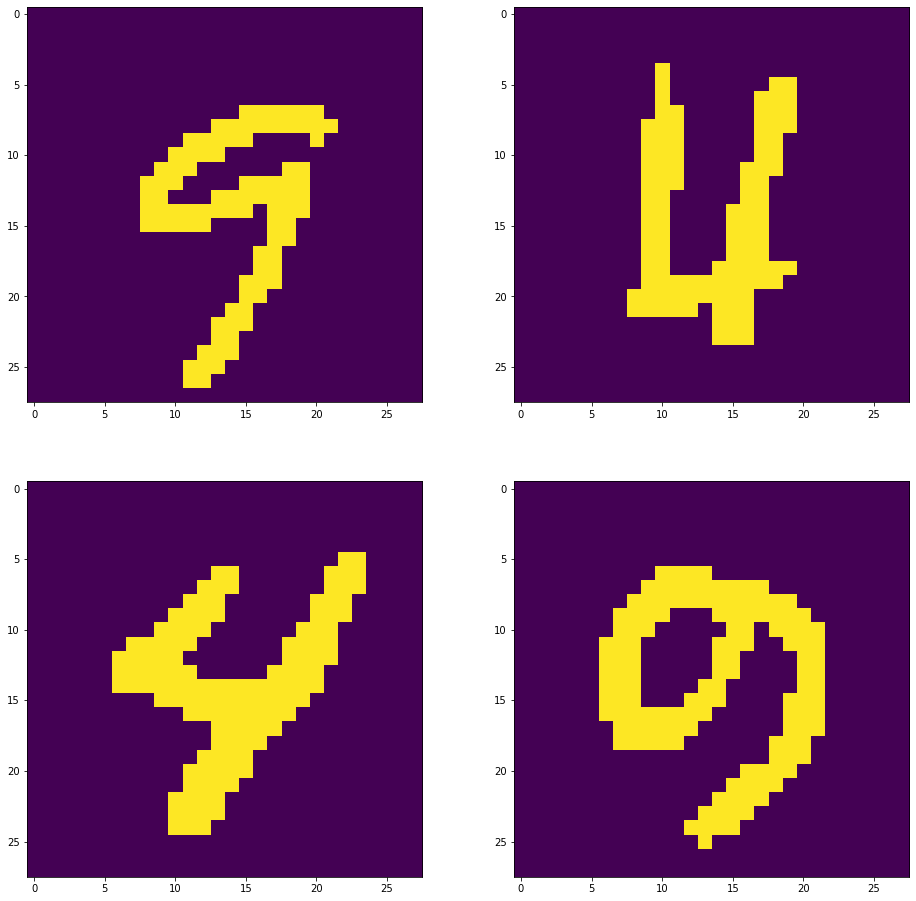

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,16))
ax1.imshow(train_data[0, :784].reshape(28, 28))
ax2.imshow(train_data[100, :784].reshape(28, 28))
ax3.imshow(test_data[0, :784].reshape(28, 28))
ax4.imshow(test_data[100, :784].reshape(28, 28))
plt.show()

I will now modify the minibatch version of the code to return the losses and gradients as well. I will use it later to plot the progress. Moreover, I will allow passing test dataset to obtain real performance of the network.

In [11]:
class Neuron:
    def __init__(self, epochs=100, random_state=None, learning_rate=0.001, batch_size=16):
        # use epochs instead of iterations
        self.epochs = epochs
        self.converged = False
        self._rand = np.random.RandomState(random_state)
        self._weights = None
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        pass
    
    def _activation(self, vals):  # activation function
        return 1 / (1 + np.exp(-vals))
    
    def fit(self, X, y, Xtest=None, ytest=None):
        # Initialize the weights
        self.converged = False
        self._weights = self._rand.uniform(-2, 2, X.shape[1])
        n_data = len(X)
        # store gradients and losses
        losses = np.zeros((self.epochs,))
        gradients = np.zeros((self.epochs, int(np.ceil(X.shape[0] / self._batch_size))))
        accuracies = np.zeros((self.epochs,))
        # Learning
        for epoch in range(self.epochs):
            # shuffle the data
            permutation = self._rand.permutation(n_data)
            # for each batch
            for batch_start in range(0, n_data, self._batch_size):
                # get batch
                batch_data = X[permutation[batch_start:batch_start+self._batch_size]]
                batch_target = y[permutation[batch_start:batch_start+self._batch_size]]
                # predict the data
                prediction = self.predict(batch_data)
                # table of gradient for each weights and gradient in the shape (samples,weights)
                gradient = np.reshape(-(batch_target - prediction) * (prediction * (1 - prediction)), newshape=(-1,1)) * batch_data
                # sum gradient over the samples
                op_gradient = self._learning_rate * np.sum(gradient, axis=0)
                # store losses and gradients
                losses[epoch] += np.sum((batch_target - prediction) ** 2, axis=0)
                gradients[epoch, int(batch_start / self._batch_size)] = op_gradient @ op_gradient
                # update the weights
                self._weights = self._weights - op_gradient
                
            # compute accuracy on the test set
            if Xtest is not None and ytest is not None:
                test_prediction = np.where(self.predict(Xtest) < 0.5, 0, 1) 
                accuracies[epoch] = np.sum(test_prediction == ytest) / len(ytest)
                
        return losses / X.shape[0], gradients, accuracies
    
    def predict(self, X):
            return self._activation(X @ self._weights)
    
    def __call__(self, X):
        return self.predict(X)

Before I run the evaluation, I have this small helper class, that I am going to use to measure the execution time of individual configurations.

In [12]:
class TimeMeasure:
    def __init__(self, label = ''):
        self._label = label
    def __enter__(self):
        self._starttime = timeit.default_timer()
        return self
    def __exit__(self, *args):
        end = timeit.default_timer()
        print(f"{self._label}{end - self._starttime:.3f}s")

Now let's try different configurations and let's see how the gradient and loss will evolve.

Note that in the standard approach people are using a test (or validation or development) set to measure the real error - generalization error on unseen data. However, in this case, we are not interested in error but rather in the behavior of the model, so it is fine not to use the test set. I will dive deeper into different datasets later on.

In [13]:
sgd = Neuron(epochs=400, random_state=47, learning_rate=0.001, batch_size=1)
with TimeMeasure('Stochastic gradient descent: '):
    sgd_loss, sgd_gradient, sgd_acc = sgd.fit(train_data, train_target, test_data, test_target)

Stochastic gradient descent: 302.348s


In [14]:
mbgd_4 = Neuron(epochs=400, random_state=47, learning_rate=0.001, batch_size=4)
with TimeMeasure("Minibatch of 4 samples: "):
    mbgd_loss_4, mbgd_gradient_4, mbgd_acc_4 = mbgd_4.fit(train_data, train_target, test_data, test_target)

Minibatch of 4 samples: 82.775s


In [15]:
mbgd_32 = Neuron(epochs=400, random_state=53, learning_rate=0.001, batch_size=32)
with TimeMeasure("Minibatch of 32 samples: "):
    mbgd_loss_32, mbgd_gradient_32, mbgd_acc_32 = mbgd_32.fit(train_data, train_target, test_data, test_target)

Minibatch of 32 samples: 25.670s


In [16]:
mbgd_128 = Neuron(epochs=400, random_state=53, learning_rate=0.001, batch_size=128)
with TimeMeasure("Minibatch of 128 samples: "):
    mbgd_loss_128, mbgd_gradient_128, mbgd_acc_128 = mbgd_128.fit(train_data, train_target, test_data, test_target)

Minibatch of 128 samples: 13.856s


In [17]:
bgd = Neuron(epochs=400, random_state=47, learning_rate=0.001, batch_size=train_data.shape[0])
with TimeMeasure('Batch gradient descent: '):
    bgd_loss, bgd_gradient, bgd_acc = bgd.fit(train_data, train_target, test_data, test_target)

Batch gradient descent: 27.345s


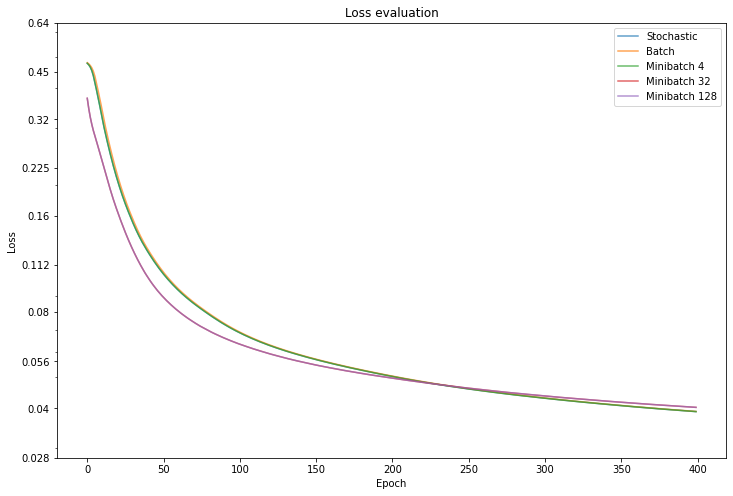

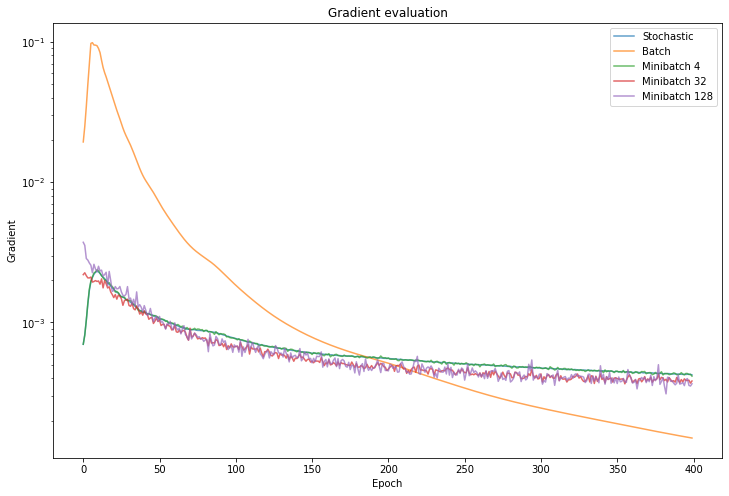

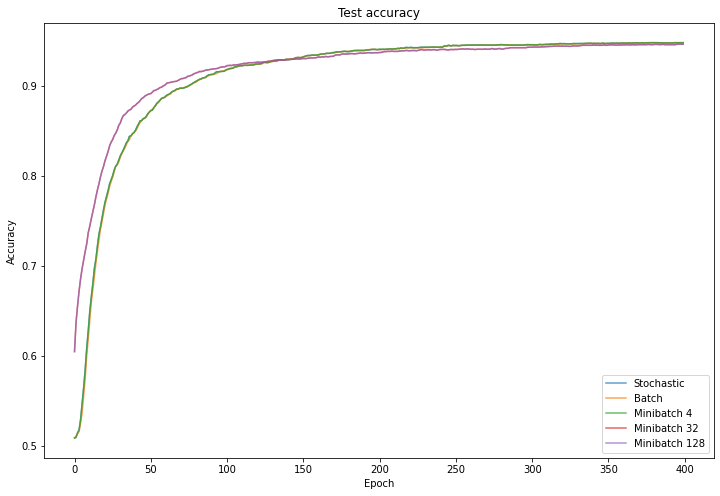

In [18]:
plt.figure(figsize=(12,8))
plt.plot(sgd_loss, label="Stochastic", alpha=0.7)
plt.plot(bgd_loss, label="Batch", alpha=0.7)
plt.plot(mbgd_loss_4, label="Minibatch 4", alpha=0.7)
plt.plot(mbgd_loss_32, label="Minibatch 32", alpha=0.7)
plt.plot(mbgd_loss_128, label="Minibatch 128", alpha=0.7)

plt.yscale('log')
ticks = [0.028, 0.04, 0.056, 0.08, 0.112, 0.16, 0.225, 0.32, 0.45, 0.64]
plt.yticks(ticks=ticks, labels=ticks)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(12,8))
plt.plot(sgd_gradient.sum(axis=1), label="Stochastic", alpha=0.7)
plt.plot(bgd_gradient.sum(axis=1), label="Batch", alpha=0.7)
plt.plot(mbgd_gradient_4.sum(axis=1), label="Minibatch 4", alpha=0.7)
plt.plot(mbgd_gradient_32.sum(axis=1), label="Minibatch 32", alpha=0.7)
plt.plot(mbgd_gradient_128.sum(axis=1), label="Minibatch 128", alpha=0.7)

plt.yscale('log')
plt.ylabel("Gradient")
plt.xlabel("Epoch")
plt.title("Gradient evaluation")
plt.legend()
plt.show()


plt.figure(figsize=(12,8))
plt.plot(sgd_acc, label="Stochastic", alpha=0.7)
plt.plot(bgd_acc, label="Batch", alpha=0.7)
plt.plot(mbgd_acc_4, label="Minibatch 4", alpha=0.7)
plt.plot(mbgd_acc_32, label="Minibatch 32", alpha=0.7)
plt.plot(mbgd_acc_128, label="Minibatch 128", alpha=0.7)

plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Test accuracy")
plt.legend()
plt.show()

What may we see in the plots? First of all, the stochastic and minibatch with small batch sizes are almost identical - green and blue lines lays on each other, and it is very hard to distinguish them. Small batches behave identical to stochastic gradient descent - however, the running time is over three times faster.

The batch version, when we use only a single update in each epoch, has gradients at the beginning much bigger and decreases under minibatch around 170th epoch - it probably converged to better local optima, as we can see in the loss evaluation loss. This is the main advantage of batch gradient descent - it always decreases the loss. This doesn't mean the algorithm is better (it may overfit). From the "test accuracy" plot, all the algorithms reached almost the same value.

Minibatch versions with bigger batch sizes have faster training with respect to epochs. We can see that in the first 100 epochs in the loss evaluation and test accuracy plots. The speedup is even in real time, as we can see from running times. The minibatch version runs over ten times faster compared to the stochastic version! That is a huge speed up and it is usually a good tradeoff, as we may train the network much faster. Note that although the minibatch with batch size 32 ran the around same amount of time as the batch version, in reality, the difference would be much bigger. MNIST dataset is not very big and it can fit fully into the memory. For bigger datasets, this doesn't need to be the case.

The last thing, that we do not see here is, that the minibatch version with a reasonably big batch size is more stable compare to the stochastic one. Its a bit visible in the test accuracy plot, where the minibatch curve is a little bit smoother. We will see this more significantly later on.

There is one more thing I want to point out. In the implementation, we sum the gradients of examples. It is this line: `op_gradient = self._learning_rate * np.sum(gradient, axis=0)`. There is a discussion, whether we should sum the gradients or mean them. First of all, it doesn't really matter for the functionality, as with proper learning rate, the resulting value is the same. There are two views - if we use the sum, we may increase the batch size and the neural network will train at the same speed (with respect to epochs). In reality, it would be training a bit faster, as there are fewer iterations in the epoch. However, the batch size needs to fit into the memory and we must be careful about the batch size. If we use too big, the gradient can explode and the result will be the same as if we set the learning rate too big. On the contrary, if we mean gradients over examples, with the bigger batch size the network will train at the same speed, but this time with respect to iterations. As there would be fewer iterations in the epoch, the network would need more epochs to train into the same level, and thus it needs more time. On the other hand, there is no problem with the gradient.

Once more, the operation doesn't really matter, as with properly scaled learning rate the resulting gradient values will be same. Both Pytorch and TensorFlow uses sum, so I will stick to it as well.